In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs_piechart")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA_PieChart"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()

In [3]:
def Normalize(arr):
    return arr / np.sum(arr)

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("CQA_PieChart", 1, "pie")


        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            pies= self.GeneratePieData(width, height)
            self.add_image("CQA_PieChart", image_id=i, path=None,
                           width=width, height=height, pies=pies)#,
                          # bg_color=bg_color, shapes=shapes)
                
    def load_image(self, image_id):
 
        info = self.image_info[image_id]
        pies = info['pies']
        image = np.ones(shape=(info['height'], info['width'], 3))
        image= self.drawImage(image, pies, info['height'],  info['width'])
        return image/255
    
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        pies = info['pies']
        count = len(pies)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (pie_name, _, _ , _ , _, _) in enumerate(info['pies']):
 
            mask[:, :, i:i+1] = self.drawImage(mask[:, :, i:i+1].copy(),
                                                [pies[i]], info['height'], info['width'], True)

        
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index('pie') for s in pies])
        return mask.astype(bool), class_ids.astype(np.int32)
        

    
    def GeneratePieData(self, height, width):
    
        min_num_obj = 3
        max_num_obj = 6
        num=np.random.randint(min_num_obj, max_num_obj + 1)

        max_obj_num = 6
        colors = np.random.uniform(0.0, 0.9,size = (max_obj_num,3))
        
        r = np.random.randint(25,45) 
        center = (int(height/2),int(width/2))
        angles = Normalize(np.random.randint(10,60,size=(num)))
        
        start_angle = 90 - np.random.randint(0,360*angles[0])/2.0
        _cur_start_angle = start_angle
        
        
        pies = []

        for i in range(num):

            _cur_end_angle = _cur_start_angle + angles[i] * 360.0

            pie_name = 'pie_{}'.format(i)
            pies.append((pie_name, colors[i], center, r, _cur_start_angle, _cur_end_angle))
            
            _cur_start_angle = _cur_end_angle
            
        return pies
     
    
    def drawImage(self, image, pies, height, width, mask=False):
        
        for pie in pies:
            center = pie[2]
            r = pie[3]
            _cur_start_angle = pie[4]
            _cur_end_angle = pie[5]
            if mask== False:
                color = pie[1]
            else:
                color = 1
                
            cv2.ellipse(image, center, (r, r), 270, -_cur_start_angle, -_cur_end_angle, color, -1)
            
        if mask is False:
            channel  = 3
            noises = np.random.uniform(0, 0.05, (height, width,channel))
            image = image + noises
            _min = 0.0
            _max = image.max()
            image -= _min
            image /= (_max - _min)
        
        return image * 255

In [18]:
dataset_train = ShapesDataset()
dataset_train.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()


In [19]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/mahsa.geshvadi001/projects/PaperCodes/1_Segmentation/Mask-RCNN-TF2/logs_piechart/cqa_piechart20230324T1432/mask_rcnn_cqa_piechart_0060.h5
Re-starting from epoch 60


In [20]:
image = dataset_train.load_image(4)

In [21]:
import matplotlib.pyplot as plt

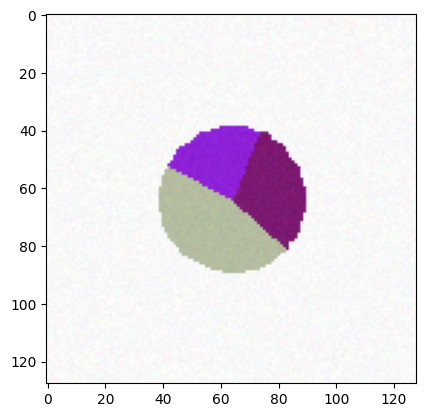

In [22]:
plt.imshow(image)

In [23]:
results = model.detect([image], verbose=1)


Processing 1 images
image                    shape: (128, 128, 3)         min:    0.07489  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.24066  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


In [24]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

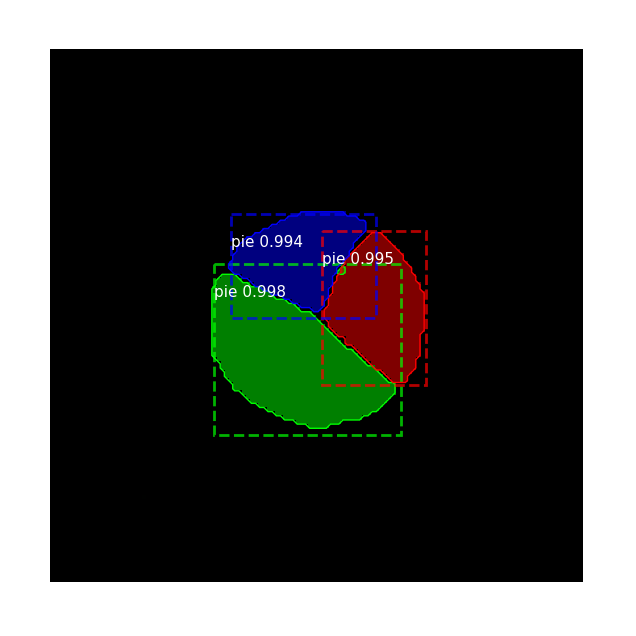

In [25]:
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

In [71]:
masks, _ = dataset_train.load_mask(4)

In [72]:
masks = masks.astype(float)


In [73]:
image = dataset_train.load_image(4)

In [75]:
import matplotlib.pyplot as plt

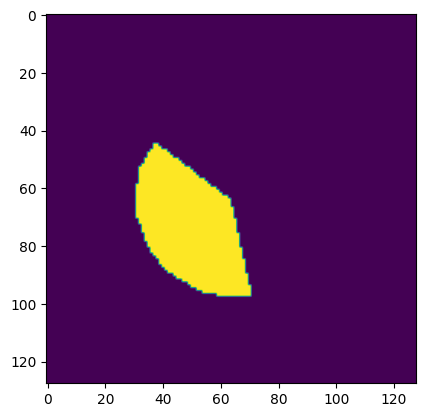

In [80]:
plt.imshow(masks[:, :, 0])

In [24]:
dataset_train.image_info

[{'id': 0,
  'source': 'CQA_PieChart',
  'path': None,
  'width': 128,
  'height': 128,
  'pies': [('pie_0',
    array([0.58676231, 0.52867111, 0.5777322 ]),
    (64, 64),
    25,
    35.5,
    190.1875),
   ('pie_1',
    array([0.8099257 , 0.49700373, 0.50965152]),
    (64, 64),
    25,
    190.1875,
    260.5),
   ('pie_2',
    array([0.26142568, 0.81959722, 0.56785829]),
    (64, 64),
    25,
    260.5,
    395.5)]},
 {'id': 1,
  'source': 'CQA_PieChart',
  'path': None,
  'width': 128,
  'height': 128,
  'pies': [('pie_0',
    array([0.53008351, 0.57311812, 0.70482244]),
    (64, 64),
    43,
    72.0,
    259.34693877551024),
   ('pie_1',
    array([0.36338578, 0.20393119, 0.12080149]),
    (64, 64),
    43,
    259.34693877551024,
    354.8571428571429),
   ('pie_2',
    array([0.44792852, 0.74022106, 0.58385047]),
    (64, 64),
    43,
    354.8571428571429,
    432.0)]},
 {'id': 2,
  'source': 'CQA_PieChart',
  'path': None,
  'width': 128,
  'height': 128,
  'pies': [('pie_0',